In [1]:
# Instalación de Biopython, necesaria para manejar datos genómicos de NCBI
!pip install biopython
!pip install tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.6 MB/s eta 0:00:00


In [54]:
import sys

print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [26]:
# Importación de librerías esenciales para análisis bioinformático
from Bio import Entrez, SeqIO  # Acceso a NCBI y manejo de archivos GenBank
import matplotlib.pyplot as plt  # Visualización de resultados
import pandas as pd  # Manejo de datos tabulares
from prettytable import PrettyTable  # Visualización de tablas en consola
from tabulate import tabulate #Genera tablas
import numpy as np #Trabajar con arreglos (arrays) multidimensionales y operaciones complejas

In [27]:
# Definición del correo asociado a Entrez (NCBI requiere esto para rastreo de consultas)
Entrez.email = "mariajo23.robayo@gmail.com" #Cambiar a su correo electrónico

In [28]:
# Función que descarga un genoma desde NCBI a partir de su ID
def obtener_genoma(id_ncbi):
    handle = Entrez.efetch(db="nucleotide", id=id_ncbi, rettype="gb", retmode="text")
    secuencia = SeqIO.read(handle, "genbank")  # Lee el archivo en formato GenBank
    handle.close()
    return secuencia

In [29]:
# IDs GenBank de dos subespecies de Treponema pallidum
id_TPA = "CP004010.2"  # Treponema pallidum subsp. pallidum (sífilis venérea)
id_TPE = "CP094485.1"  # Treponema pallidum subsp. pertenue (Pían-frambesia)

In [30]:
# Descarga de los genomas completos
genoma_TPA = obtener_genoma(id_TPA)
genoma_TPE = obtener_genoma(id_TPE)

In [7]:
# EXTRAER METADATOS GENÓMICOS
# Función extendida: Extraer metadatos + información del gen tp92
def extraer_metadatos_completos(genoma, nombre_gen="tp92"):
    organismo = genoma.annotations.get("organism", "Desconocido")
    fecha = genoma.annotations.get("date", "Desconocida")
    fuente = genoma.annotations.get("source", "No especificada")
    versión = genoma.annotations.get("accessions", [""])[0]
    keywords = genoma.annotations.get("keywords", [])
    molécula = genoma.annotations.get("molecule_type", "No especificado")
    taxon = genoma.annotations.get("taxonomy", [])

    # Buscar el gen
    secuencia_gen = ""
    proteina = ""
    encontrado = False
    for feature in genoma.features:
        if feature.type == "CDS" and nombre_gen in feature.qualifiers.get('gene', []):
            secuencia_gen = str(feature.extract(genoma).seq)
            proteina = feature.qualifiers.get('translation', ["No disponible"])[0]
            encontrado = True
            break

    if not encontrado:
        secuencia_gen = "Gen no encontrado"
        proteina = "No disponible"

    return {
        "Organismo": organismo,
        "Fuente": fuente,
        "Fecha de publicación": fecha,
        "Accesión": versión,
        "Tipo de molécula": molécula,
        "Taxonomía": ' > '.join(taxon),
        "Nombre del gen": nombre_gen,
        "Secuencia del gen (inicio)": secuencia_gen[:60] + "..." if len(secuencia_gen) > 60 else secuencia_gen,
        "Proteína codificada": proteina
    }

# Obtener metadatos completos
meta_TPA = extraer_metadatos_completos(genoma_TPA)
meta_TPE = extraer_metadatos_completos(genoma_TPE)

# Crear DataFrame
metadatos_df = pd.DataFrame([meta_TPA, meta_TPE], index=['T. pallidum pallidum', 'T. pallidum pertenue'])

# Mostrar como tabla con tabulate
from tabulate import tabulate
tabla_metadatos = tabulate(metadatos_df, headers='keys', tablefmt='fancy_grid', stralign='center')
print("\n Metadatos genómicos + gen tp92 ")
print(tabla_metadatos)



 Metadatos genómicos + gen tp92 
╒══════════════════════╤═════════════════════════════════════════════════╤═════════════════════════════════════════════════════╤════════════════════════╤════════════╤════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════╤═════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

In [31]:
# Función para calcular contenido GC y proporciones de bases con 4 decimales
def analizar_genoma(secuencia):
    secuencia_str = str(secuencia.seq)
    longitud = len(secuencia_str)
    contenido_gc = round(100 * (secuencia_str.count("G") + secuencia_str.count("C")) / longitud, 4)
    porcentaje_a = round(100 * secuencia_str.count("A") / longitud, 4)
    porcentaje_t = round(100 * secuencia_str.count("T") / longitud, 4)
    porcentaje_g = round(100 * secuencia_str.count("G") / longitud, 4)
    porcentaje_c = round(100 * secuencia_str.count("C") / longitud, 4)
    return longitud, contenido_gc, porcentaje_a, porcentaje_t, porcentaje_g, porcentaje_c

In [32]:
# Análisis básico de composición para ambos genomas
longitud_TPA, gc_TPA, a_TPA, t_TPA, g_TPA, c_TPA = analizar_genoma(genoma_TPA)
longitud_TPE, gc_TPE, a_TPE, t_TPE, g_TPE, c_TPE = analizar_genoma(genoma_TPE)

In [33]:
# Mostrar los resultados en consola
print(f"Treponema pallidum pallidum: Longitud: {longitud_TPA}, GC: {gc_TPA}%, A: {a_TPA}%, T: {t_TPA}%")
print(f"Treponema pallidum pertenue: Longitud: {longitud_TPE}, GC: {gc_TPE}%, A: {a_TPE}%, T: {t_TPE}%")

Treponema pallidum pallidum: Longitud: 1139633, GC: 52.7883%, A: 23.5315%, T: 23.6762%
Treponema pallidum pertenue: Longitud: 1140667, GC: 52.8022%, A: 23.5245%, T: 23.6733%


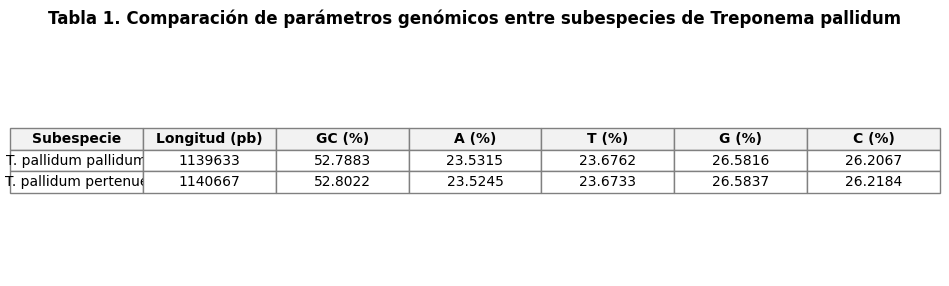

In [38]:
# Crear el DataFrame
datos = pd.DataFrame({
    'Subespecie': ['T. pallidum pallidum', 'T. pallidum pertenue'],
    'Longitud (pb)': [longitud_TPA, longitud_TPE],
    'GC (%)': [round(gc_TPA, 4), round(gc_TPE, 4)],
    'A (%)': [round(a_TPA, 4), round(a_TPE, 4)],
    'T (%)': [round(t_TPA, 4), round(t_TPE, 4)],
    'G (%)': [round(g_TPA, 4), round(g_TPE, 4)],
    'C (%)': [round(c_TPA, 4), round(c_TPE, 4)]
})

# Crear figura
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')  # Quitar ejes

# Crear tabla con formato centrado
tabla = ax.table(
    cellText=datos.values,
    colLabels=datos.columns,
    colLoc='center',
    cellLoc='center',
    loc='center'
)

# Estética tipo artículo
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.2, 1.3)

# Mejorar bordes de cabecera
for (row, col), cell in tabla.get_celld().items():
    if row == 0:
        cell.set_fontsize(10)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f2f2f2')
    cell.set_edgecolor('gray')

# Agregar título tipo artículo
plt.title("Tabla 1. Comparación de parámetros genómicos entre subespecies de Treponema pallidum",
          fontsize=12, fontweight='bold', pad=15)

# Guardar y mostrar
plt.savefig('tabla_comparativa_articulo.png', bbox_inches='tight', dpi=300)
plt.show()

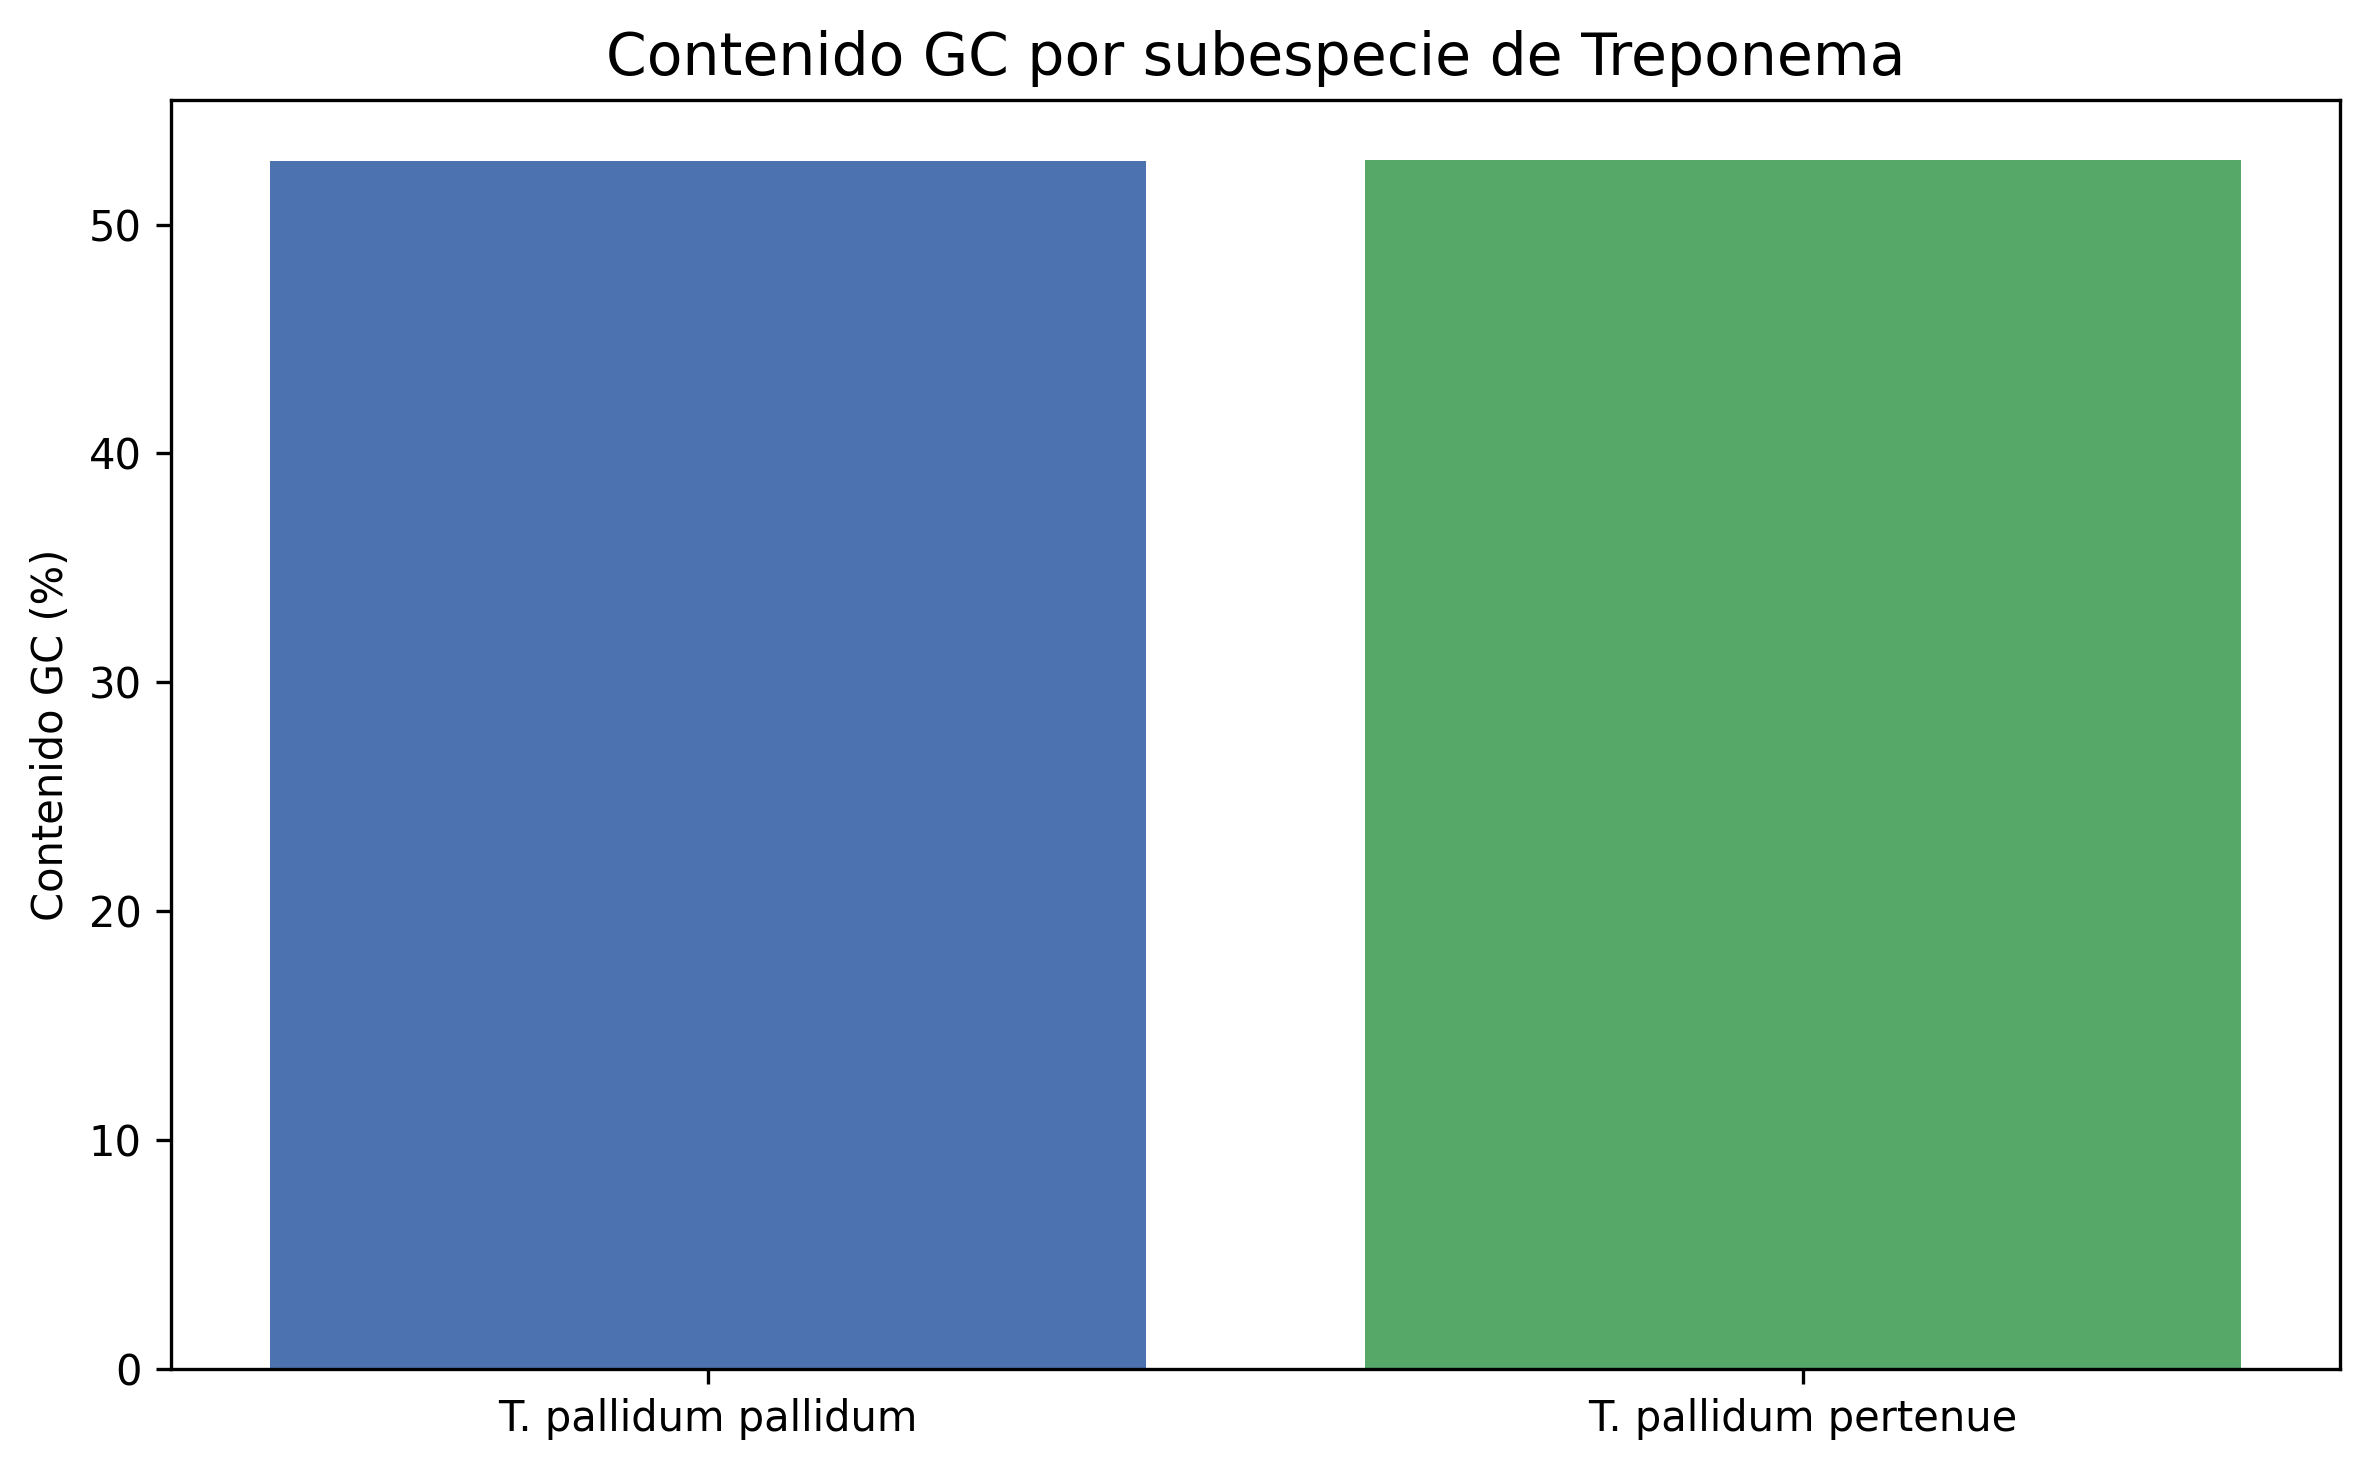

In [39]:
### GRÁFICA 1: Contenido GC por subespecie
plt.figure(figsize=(8, 5), dpi=300)
plt.bar(datos['Subespecie'], datos['GC (%)'], color=['#4C72B0', '#55A868'])
plt.title('Contenido GC por subespecie de Treponema', fontsize=14)
plt.ylabel('Contenido GC (%)')
plt.tight_layout()
plt.show()

In [ ]:
################ A nivel genómico ####################
############ ¿Habrán mayores diferencías? ############

In [40]:
nombre_gen = "tp92"

# Función para extraer una región codificante (CDS) por nombre de gen
def obtener_gen(secuencia, nombre_gen):
    for feature in secuencia.features:
        if feature.type == "CDS" and nombre_gen in feature.qualifiers.get('gene', []):
            return feature
    return None

In [41]:
# Extraer el gen tp92 de ambas subespecies
gen_TPA = obtener_gen(genoma_TPA, nombre_gen)
gen_TPE = obtener_gen(genoma_TPE, nombre_gen)


In [42]:
# Verificación de hallazgo del gen
if gen_TPA:
    print(f"{nombre_gen} encontrado en TPA")
else:
    print(f"{nombre_gen} no encontrado en TPA")
if gen_TPE:
    print(f"{nombre_gen} encontrado en TPE")
else:
    print(f"{nombre_gen} no encontrado en TPE")

tp92 encontrado en TPA
tp92 encontrado en TPE


In [43]:
# Análisis básico del gen
def analizar_gen(feature, genoma):
    secuencia_str = str(feature.extract(genoma).seq)
    longitud = len(secuencia_str)
    contenido_gc = 100 * (secuencia_str.count("G") + secuencia_str.count("C")) / longitud
    contenido_gc = round(contenido_gc, 4)  # Redondear a 4 decimales
    return longitud, contenido_gc

In [44]:
# Análisis del gen tp92 en ambas subespecies
long_tp92_TPA, gc_gen_TPA = analizar_gen(gen_TPA, genoma_TPA)
long_tp92_TPE, gc_gen_TPE = analizar_gen(gen_TPE, genoma_TPE)



In [45]:
# Resultados
print(f"{nombre_gen} en TPA: Longitud: {long_tp92_TPA}, GC: {gc_gen_TPA}%")
print(f"{nombre_gen} en TPE: Longitud: {long_tp92_TPE}, GC: {gc_gen_TPE}%")



tp92 en TPA: Longitud: 2562, GC: 52.1858%
tp92 en TPE: Longitud: 2499, GC: 52.2209%


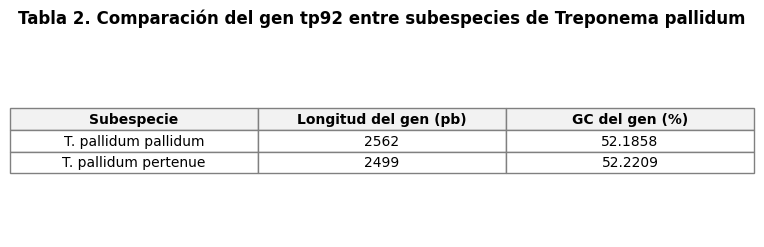

In [47]:
# Crear DataFrame con redondeo a 4 decimales
datos_gen = pd.DataFrame({
    'Subespecie': ['T. pallidum pallidum', 'T. pallidum pertenue'],
    'Longitud del gen (pb)': [long_tp92_TPA, long_tp92_TPE],
    'GC del gen (%)': [round(gc_gen_TPA, 4), round(gc_gen_TPE, 4)]
})

# Crear figura
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.axis('off')  # Quitar ejes

# Crear tabla centrada
tabla = ax.table(
    cellText=datos_gen.values,
    colLabels=datos_gen.columns,
    colLoc='center',
    cellLoc='center',
    loc='center'
)

# Estética tipo artículo
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.2, 1.3)

# Mejorar bordes y cabecera
for (row, col), cell in tabla.get_celld().items():
    if row == 0:
        cell.set_fontsize(10)
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#f2f2f2')
    cell.set_edgecolor('gray')

# Título científico
plt.title("Tabla 2. Comparación del gen tp92 entre subespecies de Treponema pallidum",
          fontsize=12, fontweight='bold', pad=15)

# Guardar como imagen
plt.savefig('tabla_tp92_comparativa.png', bbox_inches='tight', dpi=300)
plt.show()

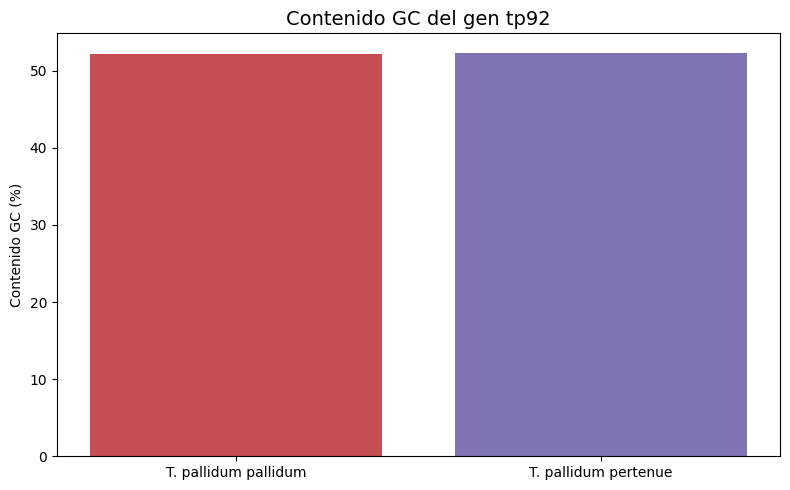

In [48]:
### GRÁFICA 2: Comparación del contenido GC del gen tp92
plt.figure(figsize=(8, 5))
plt.bar(datos_gen['Subespecie'], datos_gen['GC del gen (%)'], color=['#C44E52', '#8172B3'])
plt.title(f'Contenido GC del gen {nombre_gen}', fontsize=14)
plt.ylabel('Contenido GC (%)')
plt.tight_layout()
plt.show()


In [49]:
# --- Comparación de secuencias del gen tp92 ---
# Extraer secuencias como strings
seq_tp92_TPA = str(gen_TPA.extract(genoma_TPA).seq)
seq_tp92_TPE = str(gen_TPE.extract(genoma_TPE).seq)


In [50]:
# Igualar longitud de secuencias si son distintas
if len(seq_tp92_TPA) != len(seq_tp92_TPE):
    print("Secuencias con longitudes distintas")
    min_length = min(len(seq_tp92_TPA), len(seq_tp92_TPE))
    seq_tp92_TPA = seq_tp92_TPA[:min_length]
    seq_tp92_TPE = seq_tp92_TPE[:min_length]

Secuencias con longitudes distintas


In [51]:
# Buscar diferencias entre las dos secuencias
diferencias = [(i, seq_tp92_TPA[i], seq_tp92_TPE[i])
               for i in range(len(seq_tp92_TPA))
               if seq_tp92_TPA[i] != seq_tp92_TPE[i]]


In [52]:
# Crear DataFrame con las diferencias
df_diferencias = pd.DataFrame(diferencias, columns=['Posición', 'Nuc TPA', 'Nuc TPE'])
print(df_diferencias)

# Tabla tipo consola con PrettyTable
tabla = PrettyTable()
tabla.field_names = ["Posición", "Nuc TPA", "Nuc TPE"]
for fila in diferencias:
    tabla.add_row(fila)
print(tabla)


      Posición Nuc TPA Nuc TPE
0            0       G       A
1            3       G       C
2            4       A       T
3            5       G       C
4            6       T       A
...        ...     ...     ...
1780      2494       C       T
1781      2495       C       G
1782      2496       G       T
1783      2497       G       A
1784      2498       C       G

[1785 rows x 3 columns]
+----------+---------+---------+
| Posición | Nuc TPA | Nuc TPE |
+----------+---------+---------+
|    0     |    G    |    A    |
|    3     |    G    |    C    |
|    4     |    A    |    T    |
|    5     |    G    |    C    |
|    6     |    T    |    A    |
|    7     |    T    |    A    |
|    8     |    T    |    A    |
|    9     |    T    |    A    |
|    10    |    G    |    A    |
|    11    |    C    |    A    |
|    13    |    T    |    C    |
|    14    |    A    |    C    |
|    15    |    T    |    A    |
|    16    |    T    |    G    |
|    17    |    G    |    T    |
|    18  

In [53]:
import plotly.express as px

import plotly.express as px

# Crear vector de todas las posiciones
longitud_gen = len(seq_tp92_TPA)
df_base = pd.DataFrame({
    'Posición': range(longitud_gen),
    'Mutación': ['No'] * longitud_gen,
    'Nivel': [1] * longitud_gen,
    'Estado': ['Conservado'] * longitud_gen  # ← para la leyenda
})

# Marcar mutaciones
for pos, nuc_tpa, nuc_tpe in diferencias:
    df_base.loc[pos, 'Mutación'] = f"{nuc_tpa} → {nuc_tpe}"
    df_base.loc[pos, 'Estado'] = 'Mutación'  # ← estado para color

# Tooltip para hover
df_base['Tooltip'] = df_base.apply(
    lambda row: f"Posición: {row['Posición']}<br>Mutación: {row['Mutación']}" if row['Mutación'] != 'No' else '',
    axis=1
)

# Colores para cada estado
color_map = {
    'Conservado': 'lightgray',
    'Mutación': 'red'
}

# Gráfica interactiva
fig = px.scatter(
    df_base,
    x='Posición',
    y='Nivel',
    color='Estado',  # ← así se genera la leyenda automáticamente
    hover_name='Tooltip',
    labels={'Posición': 'Posición en el gen'},
    title=f'Mutaciones en el gen {nombre_gen} entre TPA y TPE',
    color_discrete_map=color_map
)

# Ajustes visuales
fig.update_traces(marker=dict(size=6, symbol='line-ns-open'))
fig.update_layout(
    yaxis=dict(showticklabels=False, title=''),
    xaxis_title='Posición en el gen',
    plot_bgcolor='white',
    hoverlabel=dict(bgcolor="white", font_size=12),
    margin=dict(l=40, r=40, t=60, b=40),
    legend_title_text='Estado de la posición'
)

# Mostrar
fig.show()
